<a href="https://colab.research.google.com/github/jujuGthb/Apple_Stock_Price_Prediction_II/blob/main/appl_pred_vanilla_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [49]:
# define working directory for drive

import os
project_dir = os.path.join('/content/drive/My Drive/Colab Notebooks')
model_path = os.path.join(project_dir, 'aapl_stock_prediction_transformer.keras')


In [ ]:
!pip install --upgrade yfinance
!pip install seaborn
!pip install matplotlib
!pip install scikit-learn

In [2]:
import yfinance as yf
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

#### Data collection using yfinance

In [3]:
def download_data_with_retry(ticker, start, end, interval, max_retries=5, delay=5):
    for attempt in range(max_retries):
        try:
            data = yf.download(ticker, start=start, end=end, interval=interval, auto_adjust=False)


            print("Download successful!")
            return data
        except Exception as e:
            print(f"Attempt {attempt + 1} failed: {e}")
            time.sleep(delay)
    print("All retry attempts failed.")
    return None

# Defining parameters
ticker = 'AAPL'
start_date = '2004-01-01'
end_date = '2024-01-01'
interval = '1d'

# Downloading data
data = download_data_with_retry(ticker, start_date, end_date, interval)


if data is not None:
    print(f"Number of records downloaded: {len(data)}")
else:
    print("Data download failed.")

[*********************100%***********************]  1 of 1 completed

Download successful!
Number of records downloaded: 5033


In [ ]:
data.head(5)

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
2004-01-02,0.320548,0.380000,0.388393,0.378214,0.384821,144642400
2004-01-05,0.333954,0.395893,0.399821,0.382500,0.382500,395018400
2004-01-06,0.332749,0.394464,0.400357,0.387679,0.397321,509348000
2004-01-07,0.340281,0.403393,0.407679,0.391607,0.394643,586874400
2004-01-08,0.351880,0.417143,0.423750,0.404464,0.407857,460303200


In [4]:
# Checking  MultiIndex columns
if isinstance(data.columns, pd.MultiIndex):

    data.columns = data.columns.droplevel(0)

data.columns = ['adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

In [5]:
data = data.round(2)
data.head(5)

,adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2004-01-02,0.32,0.38,0.39,0.38,0.38,144642400
2004-01-05,0.33,0.40,0.40,0.38,0.38,395018400
2004-01-06,0.33,0.39,0.40,0.39,0.40,509348000
2004-01-07,0.34,0.40,0.41,0.39,0.39,586874400
2004-01-08,0.35,0.42,0.42,0.40,0.41,460303200


## Adding Columns

#### Feature Engineering

In [8]:
# Time-Based Features
data['DayofWeek'] = data.index.dayofweek
data['Month'] = data.index.month
data['Quarter'] = data.index.quarter

# Lagged Features (previous day's values)
data['Close_Lag1'] = data['Close'].shift(1)
data['Volume_Lag1'] = data['Volume'].shift(1)


data['Price Change %'] = data['Close'].pct_change() * 100
data['Volatility_20'] = data['Close'].rolling(window=20).std()
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['EMA_50'] = data['Close'].ewm(span=50, adjust=False).mean()

# Interaction Features
data['Close_Volatility'] = data['Close'] * data['Volatility_20']



if isinstance(data.columns, pd.MultiIndex):

    data.columns = data.columns.droplevel(0)

    data.columns = ['adj Close', 'Close', 'High', 'Low', 'Open', 'Volume','Price Change %', 'Volatility_20', 'SMA_50', 'EMA_50']



data = data.round(2)




In [9]:
data.to_csv('AAPL_stock_data.csv')

## Data Processing

In [ ]:
data = pd.read_csv('AAPL_stock_data.csv', header=0, parse_dates=['Date'], index_col='Date')

data = data.bfill()



print(f"Data Info:\n {data.info}")
print(f"Sum of null data:\n {data.isnull().sum()}")






In [11]:
data.tail(5)

,adj Close,Close,High,Low,Open,Volume,DayofWeek,Month,Quarter,Close_Lag1,Volume_Lag1,Price Change %,Volatility_20,SMA_50,EMA_50,Close_Volatility
Date,,,,,,,,,,,,,,,,
2023-12-22,192.66,193.60,195.41,192.97,195.18,37122800,4,12,4,194.68,46482500.0,-0.55,2.91,185.40,188.23,563.57
2023-12-26,192.11,193.05,193.89,192.83,193.61,28919300,1,12,4,193.60,37122800.0,-0.28,2.77,185.68,188.42,534.80
2023-12-27,192.21,193.15,193.50,191.09,192.49,48087700,2,12,4,193.05,28919300.0,0.05,2.66,185.97,188.60,513.18
2023-12-28,192.64,193.58,194.66,193.17,194.14,34049900,3,12,4,193.15,48087700.0,0.22,2.43,186.30,188.80,470.50
2023-12-29,191.59,192.53,194.40,191.73,193.90,42628800,4,12,4,193.58,34049900.0,-0.54,2.26,186.63,188.94,434.43


## Visualizing Data

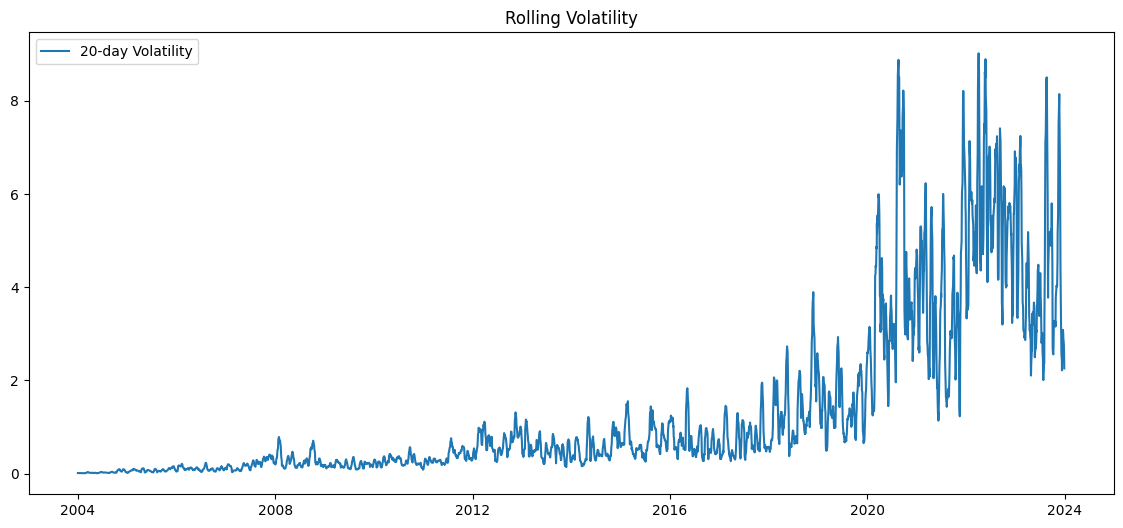

In [12]:
# Rolling volatility
data['Volatility'] = data['Close'].rolling(window=20).std()
data = data.bfill()
plt.figure(figsize=(14, 6))
plt.plot(data['Volatility'], label='20-day Volatility')
plt.title("Rolling Volatility")
plt.legend()
plt.show()

## Model Building

In [38]:
import numpy as np
import pandas as pd
from tensorflow.keras.layers import (
    Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Layer
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

#  Define the PositionalEncoding
class PositionalEncoding(Layer):
    def __init__(self, maxlen, d_model):
        super().__init__()
        self.pos_encoding = self.get_positional_encoding(maxlen, d_model)

    def get_positional_encoding(self, maxlen, d_model):
        positions = np.arange(maxlen)[:, np.newaxis]
        dims = np.arange(d_model)[np.newaxis, :]
        angle_rates = 1 / np.power(10000, (2 * (dims // 2)) / np.float32(d_model))
        angle_rads = positions * angle_rates
        sines = np.sin(angle_rads[:, 0::2])
        cosines = np.cos(angle_rads[:, 1::2])
        return np.concatenate([sines, cosines], axis=-1)

    def call(self, inputs):
        return inputs + self.pos_encoding[:inputs.shape[1], :]

# Transformer Block
def transformer_block(inputs, head_size, num_heads, ff_dim, dropout_rate):

    attention = MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    attention = Dropout(dropout_rate)(attention)
    attention = LayerNormalization(epsilon=1e-6)(inputs + attention)

    # Feed-forward network
    ff = Dense(ff_dim, activation='relu')(attention)
    ff = Dropout(dropout_rate)(ff)
    ff = Dense(inputs.shape[-1])(ff)
    ff = Dropout(dropout_rate)(ff)
    return LayerNormalization(epsilon=1e-6)(attention + ff)

# Building Transformer Model
def build_transformer(input_shape, head_size=64, num_heads=4, ff_dim=128, num_blocks=2, dropout_rate=0.1):
    inputs = Input(shape=input_shape)

# Adding Positional Encoding
    x = PositionalEncoding(maxlen=input_shape[0], d_model=input_shape[1])(inputs)

# Creating transformer blocks
    for _ in range(num_blocks):
        x = transformer_block(x, head_size, num_heads, ff_dim, dropout_rate)

# Output layer for sequence predictions
    output = Dense(1)(x)
    output = output[:, -1]

    model = Model(inputs, output)
    return model

# Compile and Train the Model
def train_model(X_train, y_train, X_val, y_val, input_shape):
    model = build_transformer(input_shape)

    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='mse',
                  metrics=['mae'])

    # Callbacks
    early_stopping = EarlyStopping(patience=20, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(factor=0.5, patience=15, min_lr=1e-6)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=32,
        callbacks=[early_stopping, reduce_lr]
    )
    return model, history

# Example Data Pipeline
def prepare_data(data, target_col, input_len):

    X, y = [], []
    for i in range(len(data) - input_len):
        X.append(data.iloc[i:i+input_len].values)
        y.append(data.iloc[i+input_len][target_col])

    X = np.array(X)
    y = np.array(y)

    # Train-test split (80%-20%)
    train_size = int(len(X) * 0.8)
    X_train, X_val = X[:train_size], X[train_size:]
    y_train, y_val = y[:train_size], y[train_size:]

    return X_train, X_val, y_train, y_val, X.shape[1:]


# Normalize the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data)
data = pd.DataFrame(data_normalized, columns=data.columns)

# Prepare sequences
target_col = 'Close'
input_len = 60
X_train, X_val, y_train, y_val, input_shape = prepare_data(data, target_col, input_len)

# Train the model
model, history = train_model(X_train, y_train, X_val, y_val, input_shape)


Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 109ms/step - loss: 0.2507 - mae: 0.3885 - val_loss: 0.1475 - val_mae: 0.3513 - learning_rate: 1.0000e-04
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 107ms/step - loss: 0.0686 - mae: 0.2069 - val_loss: 0.0996 - val_mae: 0.2884 - learning_rate: 1.0000e-04
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 107ms/step - loss: 0.0451 - mae: 0.1682 - val_loss: 0.1442 - val_mae: 0.3594 - learning_rate: 1.0000e-04
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - loss: 0.0315 - mae: 0.1400 - val_loss: 0.1219 - val_mae: 0.3305 - learning_rate: 1.0000e-04
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 108ms/step - loss: 0.0255 - mae: 0.1242 - val_loss: 0.1059 - val_mae: 0.3082 - learning_rate: 1.0000e-04
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 111ms/step - loss: 0.0206 - mae: 0.1125 - val_loss: 0.1037 - val_mae: 0.3065 - learning_rate: 1.0000e-04
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 110ms/step - loss: 0.0171 - mae: 0.1016 - val_loss: 0.1

#### Plotting the training and validation loss

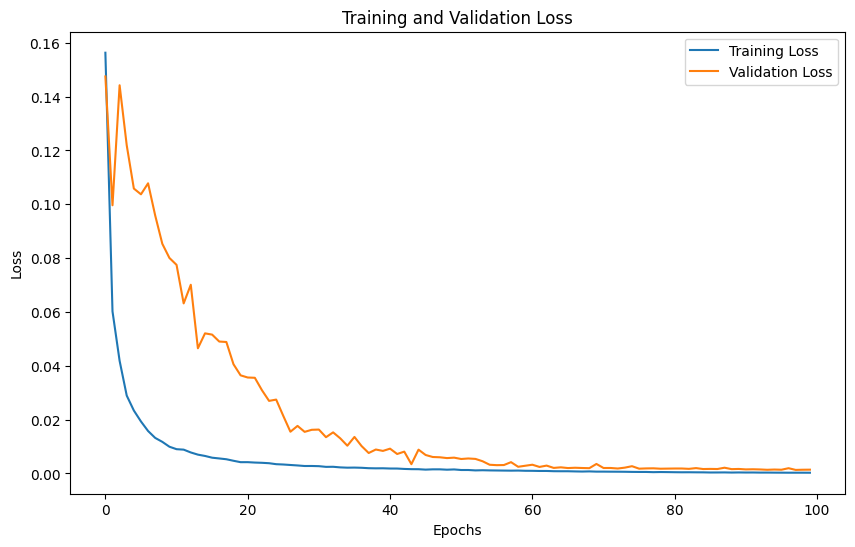

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Evaluate the Model

In [50]:

model.save(model_path)


In [41]:
X_test = X_val
y_test = y_val

In [42]:


loss, mae = model.evaluate(X_val, y_val)
print(f'Test Loss: {loss:.4f}, Test MAE: {mae:.4f}')


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0013 - mae: 0.0285
Test Loss: 0.0013, Test MAE: 0.0287


### Prediction

#### data reshaping

In [43]:
from sklearn.impute import SimpleImputer


X_train_reshape = X_train.reshape(X_train.shape[0], -1)
X_test_reshape = X_test.reshape(X_test.shape[0], -1)


imputer = SimpleImputer(strategy='constant')
X_train_reshape = imputer.fit_transform(X_train_reshape)
X_test_reshape = imputer.transform(X_test_reshape)


X_train = X_train_reshape.reshape(X_train.shape)
X_test = X_test_reshape.reshape(X_test.shape)

In [44]:
from sklearn.impute import SimpleImputer


#  Replacing NaNs with a specific value (e.g., 0)
X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)

# Remove rows with NaNs in y_train and y_test
mask = ~np.isnan(y_train)
X_train = X_train[mask]
y_train = y_train[mask]

mask_test = ~np.isnan(y_test)
X_test = X_test[mask_test]
y_test = y_test[mask_test]



In [45]:

predictions = model.predict(X_test)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step


#### Metrics Values

In [51]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predictions)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)

# Mean Absolute Percentage Error (MAPE)
# Avoid dividing by zero
mape = np.mean(np.abs((y_test - predictions) / np.clip(y_test, 1e-10, None))) * 100

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# R-squared (R²)
r2 = r2_score(y_test, predictions)  # Changed y_train to predictions

# Print the metrics
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}%")
print(f"RMSE: {rmse}")
print(f"R-squared: {r2}")

MSE: 0.0013101341365890308
MAE: 0.028698986694049092
MAPE: 30.498253740893066%
RMSE: 0.0361957751207103
R-squared: 0.9523520207966266


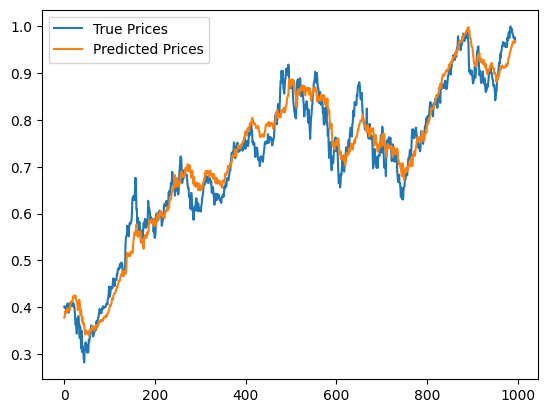

In [46]:

plt.plot(y_test, label='True Prices')
plt.plot(predictions, label='Predicted Prices')
plt.legend()
plt.show()

#### Plots the Metrics

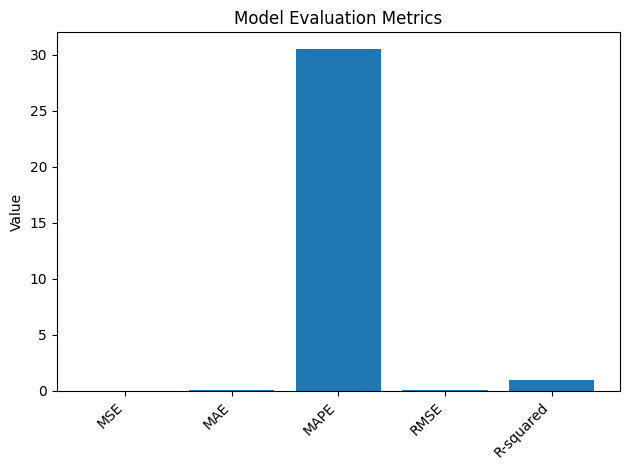

In [52]:

metrics = {
    'MSE': mse,
    'MAE': mae,
    'MAPE': mape,
    'RMSE': rmse,
    'R-squared': r2
}

# Create a bar chart
fig, ax = plt.subplots()
metric_names = list(metrics.keys())
metric_values = list(metrics.values())

ax.bar(metric_names, metric_values)
ax.set_ylabel('Value')
ax.set_title('Model Evaluation Metrics')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()